# Nettoyage des courriels des Decrypteurs

### importation des modules custom

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..')) +'\\analyser_tools'
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

C:\Users\tousi\Google Drive\radio_canada\projet\decrypteur\repo_pyMboxAnalyser\analyser_tools


In [2]:
from EmailDataFrame import *

### import python modules

In [3]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
%matplotlib inline

### definir les paths vers les données

In [4]:
cwd = pathlib.PurePath(os.getcwd())
project_root_dir = cwd.parent
theme_path = project_root_dir / "data" / "theme_words.csv"
email_raw_path = project_root_dir / "output" / 'csv_file' / 'email_raw.csv'
facebook_url_info_path = project_root_dir / 'output' / 'csv_file' / 'facebook_urls_info.csv'
youtube_url_info_path = project_root_dir / 'output' / 'csv_file' / 'youtube_urls_info.csv'
log_file_path = project_root_dir / 'output' / 'log_file' / 'url_cleaning.log'
removed_email_path = project_root_dir / 'output' / 'csv_file' / 'removed_email_from_decrypteur.csv'
dataclean_pickle_path = project_root_dir / 'output' / 'pickle_obj' / 'dataClean'


### Définir le logging

In [5]:
logging.basicConfig(filename=log_file_path, format="%(message)s", filemode='w', level=logging.INFO)


### load data et nettoyage

In [6]:
email_raw_converters = {"attach_type": lambda x: x.strip("[]").replace("'", "").lower().strip().split(", "),
                            "urls": lambda x: x.strip("[]").replace("'", "").strip().split(', ')
                            }
email_df_raw = EmailDF.from_csv(csv_path=email_raw_path, converters=email_raw_converters)
email_df_raw.read_dict_theme_from_csv(theme_path)

debut = (2020, 3, 1) # 1er mars 2020 pour le premier courriel
fin = (9999, 12, 30) # infini

email_df = (email_df_raw.filt_by_date(start_date=debut, end_date=fin) #conserver entre debut et fin
            .remove_email_by_from(logpath=removed_email_path) #log les courriels retirer 
            .clean_urls() #courriel spam (antivirus), repetition de domaine
            .add_domain_column() #trouver domaine des urls restants
            .add_has_url_column() #ajouter s'il y a des urls ou non
            .add_text_column() # combiner body et titre du courriel, puis retirer emoji, non-roman text, saut de ligne et tab
            .add_theme_column() # tagger les courriels à partir du text
            .add_source_column()) # trouver les sources (comme domaine, mais sans répétition)

 61%|█████████████████████████████████████████████▍                             | 3170/5230 [00:00<00:00, 31469.47it/s]

creating domain column


  2%|█▊                                                                           | 127/5230 [00:00<00:04, 1260.81it/s]

creating has_url column


  1%|▌                                                                              | 34/5230 [00:00<00:15, 337.41it/s]

creating text column


  0%|▏                                                                              | 16/5230 [00:00<00:33, 157.28it/s]

tagging theme to email


100%|█████████████████████████████████████████████████████████████████████████████| 5230/5230 [00:28<00:00, 184.04it/s]


tagging source to email


### Des courriels en datant de :

In [7]:
print("DE ",email_df_raw.df.datetime.min()," À ", email_df_raw.df.datetime.max())

DE  2019-04-18 12:40:52  À  2020-08-31 09:54:29


### Nombre de courriels

In [8]:
email_df_raw.df.shape[0]

6497

### Nombre après nettoyage

In [9]:
email_df.df.shape[0]

5230

### courbe avant filtre par date

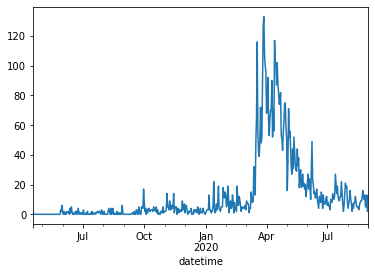

In [10]:
email_df_raw.df.set_index("datetime").resample('D').count().email_id.plot()

### Après filtre par date

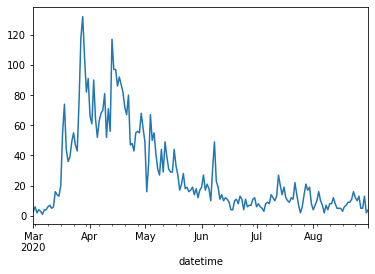

In [11]:
email_df.df.set_index("datetime").resample('D').count().email_id.plot()

### Courriels avant 1er mars retiré

In [12]:
email_df_raw.df.shape[0] - email_df_raw.filt_by_date(debut, fin).df.shape[0]

834

### Courriels de réponse des décrypteurs retiré

In [13]:
email_df_raw.filt_by_date(debut, fin).df.shape[0] - email_df_raw.filt_by_date(debut, fin).remove_email_by_from().df.shape[0]

433

### Restant à analyser

In [14]:
email_df_raw.filt_by_date(debut, fin).remove_email_by_from().df.shape[0]

5230

### Nettoyage des URLs

In [15]:
# df_log = pd.read_clipboard(header=None) #create csv from log file using excel and copy everything before running this cell


In [16]:
df_log

NameError: name 'df_log' is not defined

#### Nombre d'URLs modifié ou supprimé

In [ ]:
df_log.groupby(0).count()[1]

### exemple modif

### Youtube

In [ ]:
df_log[df_log[0]=='yt_url_modif'][[0,1,2]]

### Facebook

In [ ]:
df_log[df_log[0]=='fb_url_modif'][[0,1,2]]

### Exemple supprimer pour spam (domain in ['microsoft', 'can01', 'safelinks', 'mailtrack', 'avast', 'aka', 'avg', 'symantec', 'xx']

In [ ]:
df_log[df_log[0]=='spam_url_log'][[0,1,2]]

### retiré car il y avait deja 5 urls du meme domaine dans le courriel

In [ ]:
df_log[df_log[0]=='rep_url_removed'][[0,1,2]]

### retrait par courriel en raison d'une répétion de domaine dans un même courriel

In [ ]:
df_log[df_log[0]=='rep_url_removed'][[0,1,2]][1].value_counts()